In [1]:
import os
from functools import reduce
import pandas as pd
from datetime import datetime
from dateutil.parser import parse
#from math import log, floor
#import csv
import requests
import json
#from collections import deque
import numpy as np
#from IPython.display import HTML
%matplotlib inline
import matplotlib.pyplot as plt
from config import apikey
from config import ckey
#from chart_studio import plotly as py
import plotly.graph_objects as go

In [2]:
# Call congress info
version =  'v1'
response = requests.get(
    'https://api.propublica.org/congress/v1/117/senate/members.json',
    headers={'X-API-Key': apikey},
).content

data = json.loads(response)

members = data['results'][0]['members']

# For Debug only,  comment out
#for member in members:
#    print(member['last_name'], member['state'], member['party'])

membersdf = pd.DataFrame(members)
stategrpcts = membersdf.groupby(['state','party'])['party'].count()


In [3]:
# new_df = membersdf[membersdf['state'] == 'CA']
# new_df.head()
# membersdf.head()
stategrpcts.head()

state  party
AK     R        2
AL     R        2
AR     R        2
AZ     D        2
CA     D        3
Name: party, dtype: int64

In [4]:
states = membersdf['state'].unique()
print(len(states))

50


In [5]:
## Assign Value for each state based on party 
party_df = stategrpcts.unstack()

#Create a series with the map 
# party_df['Color'] = party_df.D.map(lambda x: 'Blue' if x >= 2 else "")
# blue_party_series = party_df[party_df['Color'] == 'Blue']['Color']

# party_df['Color'] = party_df.R.map(lambda x: 'Red' if x >= 2 else "")
# red_party_series = party_df[party_df['Color'] == 'Red']['Color']

# party_df['Color'] = party_df.ID.map(lambda x: 'White' if x >= 2 else "")
# white_party_series = party_df[party_df['Color'] == 'White']['Color']

# complete_party_df = pd.concat([blue_party_series, red_party_series, white_party_series])

# WHERE WE LEFT OFF --> Finish putting purple into series 
#party_df['Color'] = party_df[~party_df.index.isin(complete_party_df)].map(lambda x: 'Purple')
#party_df
# purple_party_series = party_df[]

# complete_party_df
# party_df['Color'] = party_df.ID.map(lambda x: 'White' if x >= 2 else "")
# party_df
# new_df = df.loc[df[“column”] == “unique variable”, :]
party_df.head()

party,D,ID,R
state,,,
AK,NaN,NaN,2.0
AL,NaN,NaN,2.0
AR,NaN,NaN,2.0
AZ,2.0,NaN,NaN
CA,3.0,NaN,NaN


In [6]:
def polColor(dem, ind, rep):
    if dem >= 2 :
        color='blue'
    elif ind >= 2 :
        color='white'
    elif rep >= 2 :
        color='red'
    else:
        color='purple'
    return color

party_df['Color'] = party_df.apply(lambda x: polColor(x['D'], x['ID'], x['R']), axis=1)
party_df.head()

party,D,ID,R,Color
state,,,,
AK,NaN,NaN,2.0,red
AL,NaN,NaN,2.0,red
AR,NaN,NaN,2.0,red
AZ,2.0,NaN,NaN,blue
CA,3.0,NaN,NaN,blue


In [7]:
statecolor = party_df['Color']

In [8]:
# Call covid info
version =  'v1'
response = requests.get(
    'https://data.cdc.gov/resource/9mfq-cb36.json?created_at=2020-12-09T14:45:40.234'
).content

covid_data = json.loads(response)


coviddf = pd.DataFrame(covid_data)
coviddf.head()

,submission_date,state,tot_cases,conf_cases,prob_cases,new_case,pnew_case,tot_death,conf_death,prob_death,new_death,pnew_death,created_at,consent_cases,consent_deaths
0,2020-12-08T00:00:00.000,FSM,0,0.0,0,0.0,0,0,0.0,0,0.0,0,2020-12-09T14:45:40.234,Agree,Agree
1,2020-12-08T00:00:00.000,GU,7039,NaN,NaN,20.0,1,113,NaN,NaN,0.0,0,2020-12-09T14:45:40.234,Not agree,Not agree
2,2020-12-08T00:00:00.000,MI,443076,410295.0,32781,6676.0,767,10625,10138.0,487,203.0,12,2020-12-09T14:45:40.234,Agree,Agree
3,2020-12-08T00:00:00.000,DC,23589,NaN,NaN,270.0,0,701,NaN,NaN,0.0,0,2020-12-09T14:45:40.234,NaN,NaN
4,2020-12-08T00:00:00.000,IN,392663,NaN,NaN,5385.0,0,6410,6109.0,301,126.0,3,2020-12-09T14:45:40.234,Not agree,Agree


In [9]:
coviddf.count()

submission_date    56
state              56
tot_cases          56
conf_cases         32
prob_cases         32
new_case           56
pnew_case          56
tot_death          56
conf_death         33
prob_death         33
new_death          56
pnew_death         56
created_at         56
consent_cases      51
consent_deaths     51
dtype: int64

In [10]:
covidstatesdf = coviddf[coviddf['state'].isin(states)][['state','tot_cases','tot_death']]
covidstatesdf.count()

state        46
tot_cases    46
tot_death    46
dtype: int64

In [11]:
covidstatesdf.head()

,state,tot_cases,tot_death
2,MI,443076,10625
4,IN,392663,6410
5,ID,113905,1074
6,MS,171584,4042
7,LA,254562,6652


In [12]:
cvdcolor = pd.merge(covidstatesdf, statecolor, on='state')
cvdcolor.head()

,state,tot_cases,tot_death,Color
0,MI,443076,10625,blue
1,IN,392663,6410,red
2,ID,113905,1074,red
3,MS,171584,4042,red
4,LA,254562,6652,red


In [13]:
# Call congress info
version =  'v1'
response = requests.get(
    f'https://api.census.gov/data/2019/acs/acs1?key={ckey}&get=NAME,B01001_001E&for=state:*'
).content

data = json.loads(response)[1:]
statepop = pd.DataFrame(data, columns=['State','Population','State_id'])

statepop

,State,Population,State_id
0,Illinois,12671821,17
1,Georgia,10617423,13
2,Idaho,1787065,16
3,Hawaii,1415872,15
4,Indiana,6732219,18
5,Iowa,3155070,19
6,Kansas,2913314,20
7,Kentucky,4467673,21
8,Louisiana,4648794,22
9,Maine,1344212,23


In [14]:
state_abb = pd.read_csv('state-abbreviations.csv',encoding='utf-8')

state_abb.head()

,State,Abbreviation
0,Alabama,AL
1,Alaska,AK
2,Arizona,AZ
3,Arkansas,AR
4,California,CA


In [15]:
statepop = statepop.merge(state_abb, on='State')

statepop.head()

,State,Population,State_id,Abbreviation
0,Illinois,12671821,17,IL
1,Georgia,10617423,13,GA
2,Idaho,1787065,16,ID
3,Hawaii,1415872,15,HI
4,Indiana,6732219,18,IN


In [32]:
covidbystate = cvdcolor.merge(statepop,left_on='state', right_on='Abbreviation')
covidbystate['tot_cases'] = pd.to_numeric(covidbystate['tot_cases'])
covidbystate['Population'] = pd.to_numeric(covidbystate['Population'])
covidbystate['PercentInfected'] = (covidbystate['tot_cases'].astype(float)/covidbystate['Population'].astype(float))*100
covidbystate['PercentByDeaths'] = (covidbystate['tot_death'].astype(float)/covidbystate['Population'].astype(float))*100


covidbystate

,state,tot_cases,tot_death,Color,State,Population,State_id,Abbreviation,PercentInfected,PercentByDeaths
0,MI,443076,10625,blue,Michigan,9986857,26,MI,4.436591,0.106390
1,IN,392663,6410,red,Indiana,6732219,18,IN,5.832594,0.095214
2,ID,113905,1074,red,Idaho,1787065,16,ID,6.373859,0.060099
3,MS,171584,4042,red,Mississippi,2976149,28,MS,5.765303,0.135813
4,LA,254562,6652,red,Louisiana,4648794,22,LA,5.475872,0.143091
5,RI,67067,1470,blue,Rhode Island,1059361,44,RI,6.330892,0.138763
6,ME,14455,246,purple,Maine,1344212,23,ME,1.075351,0.018301
7,NC,404032,5605,red,North Carolina,10488084,37,NC,3.852296,0.053442
8,AZ,378157,6973,blue,Arizona,7278717,04,AZ,5.195380,0.095800
9,VA,267129,4281,blue,Virginia,8535519,51,VA,3.129616,0.050155


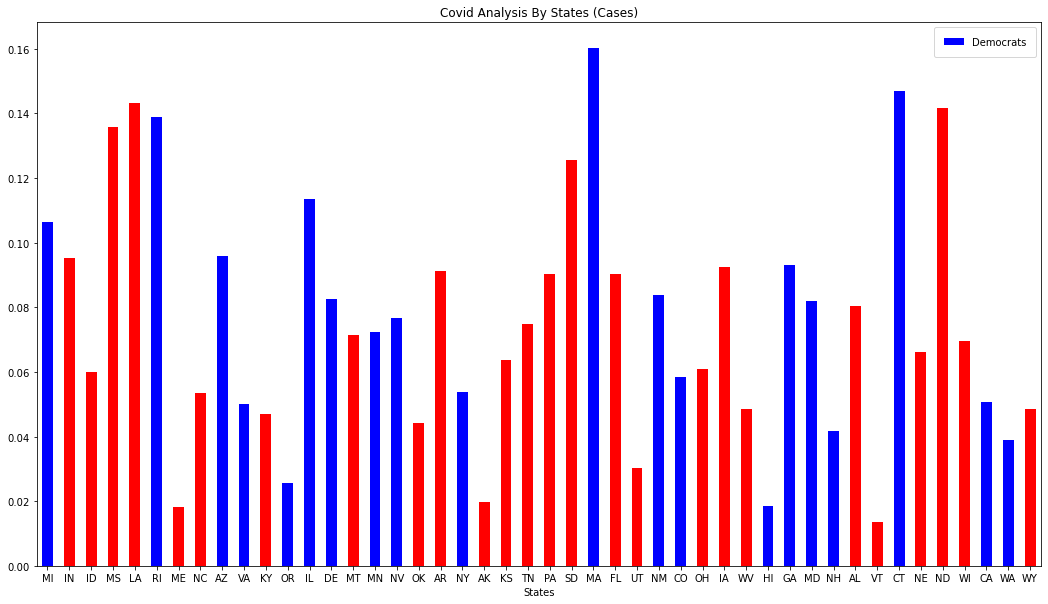

In [34]:
# Bar Graph - Percent By Cases 
    
percentInfected = covidbystate['PercentByDeaths']
states = covidbystate['state']

colors = ['blue' if (x == "blue") else 'red' for x in covidbystate["Color"]]

df = pd.DataFrame({'States':states, 'Percent of Population Infected':percentInfected})

ax = df.plot.bar(x='States', y='Percent of Population Infected', rot=0, figsize=(18, 10), width=0.5, color=colors)
# stacked bar charts 

plt.title("Covid Analysis By States (Cases)")
ax.legend(["Democrats", "Republicans"], borderpad=1);

plt.show()

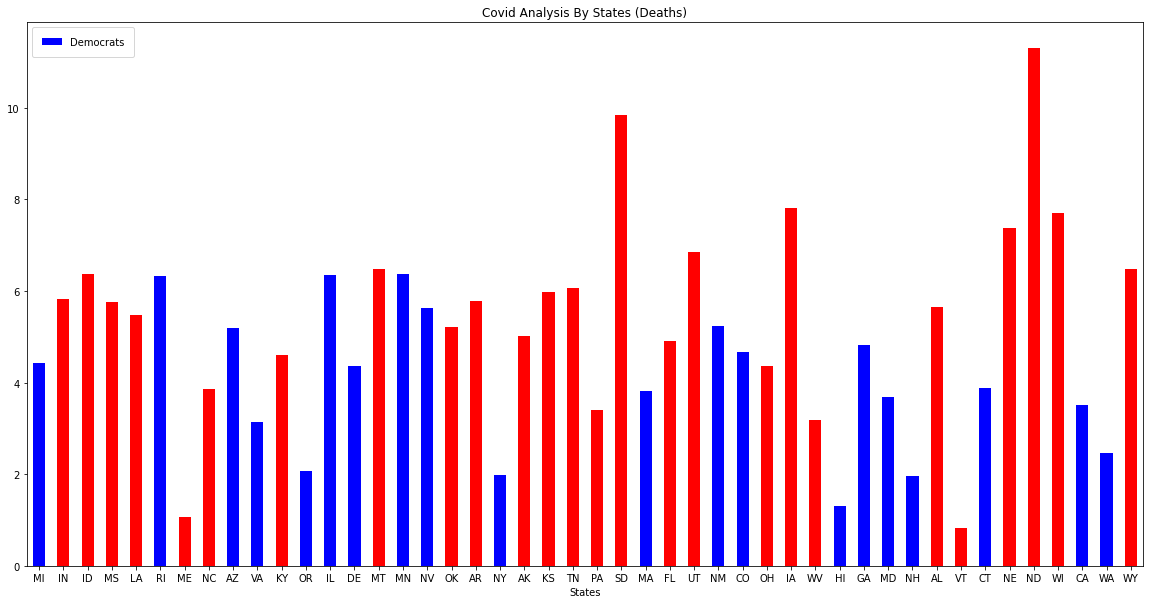

In [35]:
# Bar Graph - Percent By Deaths 
    
percentByDeaths = covidbystate['PercentInfected']
states = covidbystate['state']

colors = ['blue' if (x == "blue") else 'red' for x in covidbystate["Color"]]

df = pd.DataFrame({'States':states, 'Percent of Population Infected': percentByDeaths})
ax = df.plot.bar(x='States', y='Percent of Population Infected', rot=0, figsize=(20, 10), width=0.5, color=colors)
# stacked bar charts 

plt.title("Covid Analysis By States (Deaths)")
ax.legend(["Democrats", "Republicans"], borderpad=1);

plt.show()

In [21]:
stcolor = covidbystate['Color']

fig = go.Figure(data=go.Choropleth(
    locations=covidbystate['state'], # Spatial coordinates
    z = covidbystate['tot_cases'].astype(float), # Data to be color-coded
    locationmode = 'USA-states', # set of locations match entries in `locations`
    #color_discrete_map=[df.index, df['Color']],
    colorscale = 'Reds',
    colorbar_title = "Total Cases (Mil)",
))

fig.update_layout(
    title_text = 'Covid by State',
    geo_scope='usa', # limit map scope to USA
)

fig.show()

In [21]:
#Population by State

fig = go.Figure(data=go.Choropleth(
    locations=covidbystate['state'], # Spatial coordinates
    z = covidbystate['Population'].astype(float), # Data to be color-coded
    locationmode = 'USA-states', # set of locations match entries in `locations`
    #color_discrete_map=[df.index, df['Color']],
    colorscale = 'Blues',
    colorbar_title = "Total Population (Mil)",
))

fig.update_layout(
    title_text = 'Covid by State',
    geo_scope='usa', # limite map scope to USA
)

fig.show()

In [47]:
import plotly.express as px

fig = px.scatter(covidbystate,
    x="PercentInfected", y="tot_cases", size="Population", color="Color",
    log_x=True, size_max=60, title="gggg")
fig.show()

In [ ]:
for xd, yd in zip(x_data, y_data):
        
        median = np.median(yd) # find the median
        color = 'rgb' + str(cmap(norm(median))[0:3]) # normalize
        
        traces.append(go.Box(
            y=yd,
            name=xd,
            boxpoints='all',
            jitter=0.5,
            whiskerwidth=0.2,
            fillcolor=color,      # add the box plot color
            marker=dict(
                size=2,
            ),
            line=dict(width=1)
        ))

In [ ]:
import plotly.express as px

df = px.data.election()
geojson = px.data.election_geojson()

fig = px.choropleth(df, geojson=geojson, color="winner",
                    locations="district", featureidkey="properties.district",
                    projection="mercator", hover_data=["Bergeron", "Coderre", "Joly"]
                   )
fig.update_geos(fitbounds="locations", visible=False)
fig.update_layout(margin={"r":0,"t":0,"l":0,"b":0})
fig.show()

In [ ]:
df.head()